# Pixelated light in _lenstronomy_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.plot_util import nice_colorbar

%matplotlib inline

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
# data specifics
#background_rms = 0 # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
#psf_fwhm = 0  # full width half max of PSF, in delta_pix units

num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2) -->  if 1, means you we work in pixel units

subgrid_res_source = 2

In [4]:
# data specification (coordinates, etc.)
#kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    #'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
#kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.2, 'e2': 0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source = {'amp': 2000, 'R_sersic': 0.6, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.3, 'center_y': 0.3}
kwargs_source = [kwargs_sersic_ellipse_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [5]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [6]:
# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
#bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#noise = bkg + poisson
image_sim = image_sim_no_noise  # + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

In [7]:
# get the coordinates arrays of image plane (the 'thetas')
x_grid, y_grid = data_class.pixel_coordinates
x_grid_1d = lenstro_util.image2array(x_grid)
y_grid_1d = lenstro_util.image2array(y_grid)
theta_x_1d = x_grid_1d
theta_y_1d = y_grid_1d

## get the deflection angles
#alpha_x_1d, alpha_y_1d = lens_model_class.alpha(x_grid_1d, y_grid_1d, kwargs_lens)
#alpha_x = lenstro_util.array2image(alpha_x_1d)
#alpha_y = lenstro_util.array2image(alpha_y_1d)
#print(alpha_x.shape)

# get the magnification
magnif_1d = lens_model_class.magnification(x_grid_1d, y_grid_1d, kwargs_lens)
magnif = lenstro_util.array2image(magnif_1d)
abs_magnif_1d = np.abs(magnif_1d)

# backward ray-tracing to get source coordinates in image plane (the 'betas')
beta_x_1d, beta_y_1d = lens_model_class.ray_shooting(theta_x_1d, theta_y_1d, kwargs_lens)

In [8]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                      subgrid_res=subgrid_res_source)

x_grid_src = lenstro_util.array2image(x_grid_src_1d)
y_grid_src = lenstro_util.array2image(y_grid_src_1d)
theta_x_src_1d = x_grid_src_1d
theta_y_src_1d = y_grid_src_1d

# get the light distribution in source plane
source_sim_1d = source_model_class.surface_brightness(theta_x_src_1d, theta_y_src_1d, kwargs_source)
source_sim = lenstro_util.array2image(source_sim_1d)

In [9]:
# get an automatic mask for that includes the lensed source light
threshold = 5  # TODO : when noise is added, take a multiple of the background noise level
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

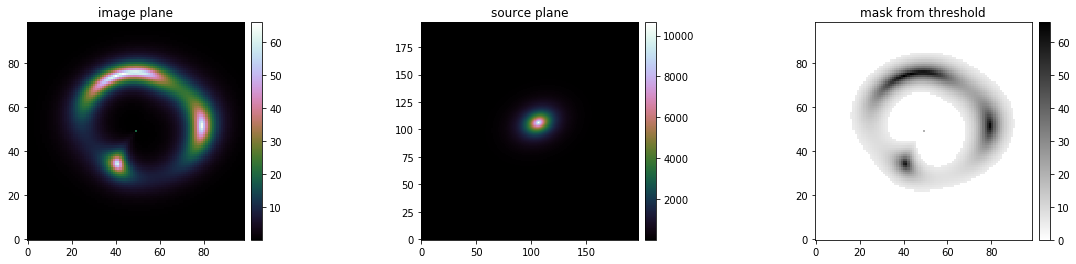

In [10]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold")
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()

## Build the mapping between image and source plane

In [11]:
from slitronomy.Lensing.lensing_operator import LensingOperator

lensing_op_class = LensingOperator(data_class, lens_model_class, subgrid_res_source=subgrid_res_source, 
                                   minimal_source_plane=False, min_num_pix_source=10, matrix_prod=True)

In [12]:
def get_size(matrix):
    # get size of a numpy array in MB
    return matrix.size * matrix.itemsize / (1e3*1024)

def get_size_from_sparse(matrix):
    return matrix.toarray().nbytes / (1e3*1024)

def get_sparse_size(matrix):
    # get size of a sparse matrix in MB
    return (matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes) / (1e3*1024)

mass_mapping_list = lensing_op_class.lens_mapping_list(kwargs_lens)
mass_mapping_sparse = lensing_op_class.lens_mapping_matrix(kwargs_lens)

print("List size [MB] :", get_size(mass_mapping_list))
print("Array original size [MB] :", get_size_from_sparse(mass_mapping_sparse))
print("Array optimized size [MB] :", get_sparse_size(mass_mapping_sparse))

List size [MB] : 0.0765703125
Array original size [MB] : 3001.86253125
Array optimized size [MB] : 0.15314453125


In [13]:
# display image to source mapping

#fig = plt.figure(figsize=(20, 20))
#ax = plt.subplot2grid((1, 1), (0, 0), fig=fig)
#ax.matshow(mass_mapping_sparse.toarray(), cmap='gray_r')

## Check mappings

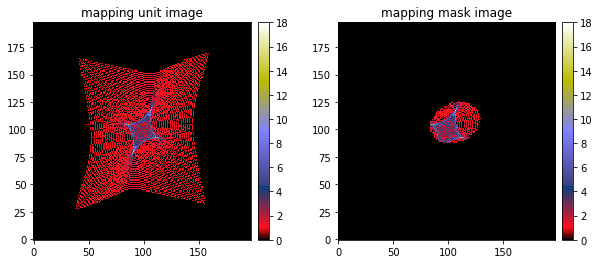

In [14]:
# test images
image_ones_1d = np.ones_like(image_sim_1d)
image_mask_1d  = lenstro_util.image2array(image_mask)
source_ones = lenstro_util.array2image(lensing_op_class.image2source(image_ones_1d, kwargs_lens, 
                                                                     test_unit_image=True))
source_mask = lenstro_util.array2image(lensing_op_class.image2source(image_mask_1d, kwargs_lens, 
                                                                     test_unit_image=True))

fig = plt.figure(figsize=(10, 4))

ax = plt.subplot2grid((1, 2), (0, 0), fig=fig)
ax.set_title("mapping unit image")
im = ax.imshow(source_ones, origin='lower', cmap='gist_stern')
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1), fig=fig)
ax.set_title("mapping mask image")
im = ax.imshow(source_mask, origin='lower', cmap='gist_stern')
nice_colorbar(im)
plt.show()

## Lensing tests

In [15]:
# from source plane to image plane, by matrix product : D = F S
S_vector = source_sim_1d
S = source_sim
start = time.time()
D_vector = lensing_op_class._source2image_matrix(S_vector)
print("runtime, source to image (matrix product) : {:.3e} s".format(time.time()-start))
D_mp = lenstro_util.array2image(D_vector)

# from source plane to image plane : "D = F S"
S_vector = source_sim_1d
start = time.time()
D_vector = lensing_op_class.source2image(S_vector)
print("runtime, source to image : {:.3e} s".format(time.time()-start))
D = lenstro_util.array2image(D_vector)

# test equality of both methods
np.testing.assert_equal(D_mp, D)

# from image plane to source plane : "S = F^{-1} D"
D_vector2 = image_sim_1d
D2 = image_sim
start = time.time()
S_vector2 = lensing_op_class.image2source(D_vector2)
print("runtime, image to source : {:.3e} s".format(time.time()-start))
S2 = lenstro_util.array2image(S_vector2)

# NOTE : hence, the numpy inversion of F is not equivalent of the unlensing effect

runtime, source to image (matrix product) : 5.341e-04 s
runtime, source to image : 2.770e-04 s
runtime, image to source : 4.092e-01 s


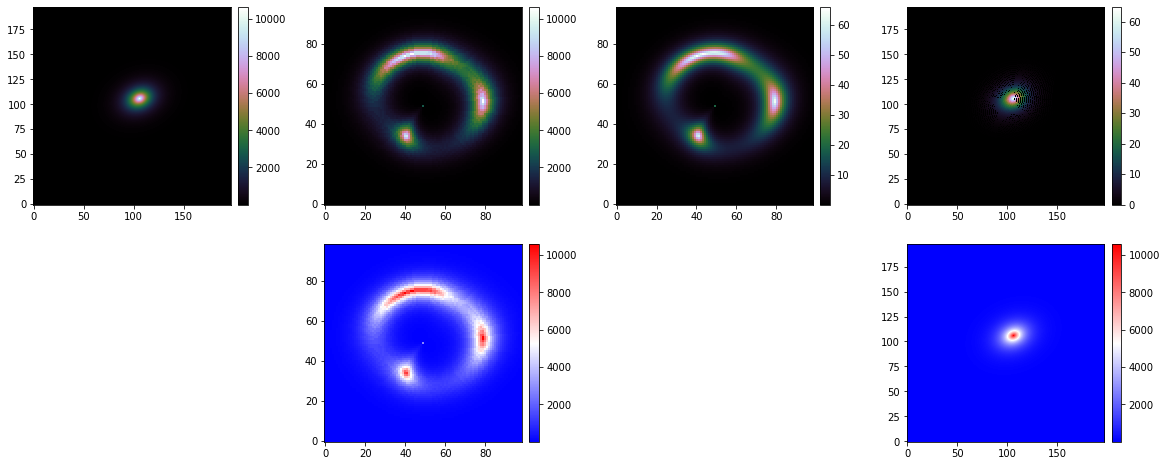

In [16]:
fig = plt.figure(figsize=(20, 8))

ax = plt.subplot2grid((2, 4), (0, 0), fig=fig)
im = ax.imshow(S, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 1), fig=fig)
im = ax.imshow(D, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 2), fig=fig)
im = ax.imshow(D2, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 3), fig=fig)
im = ax.imshow(S2, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (1, 1), fig=fig)
im = ax.imshow(D-D2, origin='lower', cmap='bwr')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (1, 3), fig=fig)
im = ax.imshow(S-S2, origin='lower', cmap='bwr')
nice_colorbar(im)

## Check for identity operation

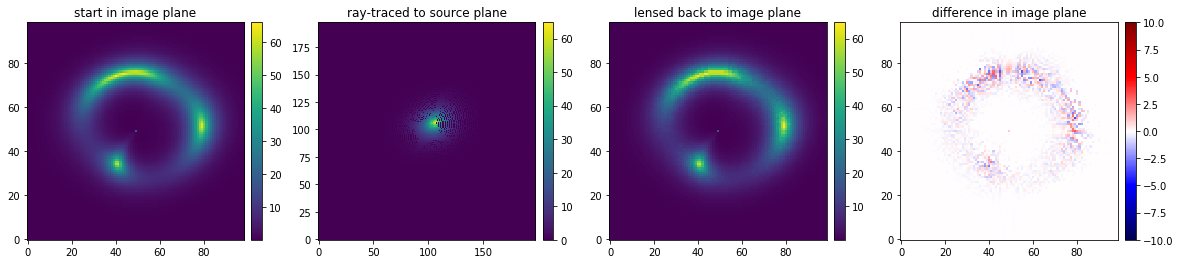

In [17]:
# check that applying F^{-1} then F gives back the same result
# (the inverse can never be true because lensed pixels from source plane are mapped outside image plane)

D = image_sim_1d
S = lensing_op_class.image2source(D)
D_prime = lensing_op_class.source2image(S)

D = lenstro_util.array2image(D)
S = lenstro_util.array2image(S)
D_prime = lenstro_util.array2image(D_prime)


fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 4), (0, 0), fig=fig)
ax.set_title("start in image plane")
im = ax.imshow(D, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 1), fig=fig)
ax.set_title("ray-traced to source plane")
im = ax.imshow(S, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 2), fig=fig)
ax.set_title("lensed back to image plane")
im = ax.imshow(D_prime, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 3), fig=fig)
ax.set_title("difference in image plane")
im = ax.imshow(D-D_prime, origin='lower', cmap='seismic', vmin=-10, vmax=10)
nice_colorbar(im)

plt.show()

## Fill holes in the 'source plane' mask

(198, 198)


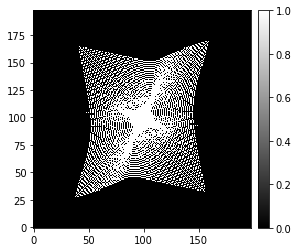

In [18]:
# map ones from image plane to source plane
ones_image_plane = np.ones_like(image_sim)
ones_delensed = lensing_op_class.image2source_2d(ones_image_plane)
print(ones_delensed.shape)

im = plt.imshow(ones_delensed, cmap='gray', origin='lower')
nice_colorbar(im)
plt.show()

### Use morphological operation (erosion) to fill gaps

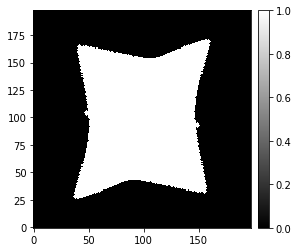

In [19]:
from scipy.ndimage import morphology

def apply_erosion(array, strength=1):
    # swap 1s and 0s
    array = 1 - array
    # erosion operation
    array = morphology.binary_erosion(array, iterations=strength)
    # swap back 1s and 0s
    array = 1 - array
    # erosion has introduced artifacts on the edges, so we remove them
    array[:strength, :] = 0
    array[-strength:, :] = 0
    array[:, :strength] = 0
    array[:, -strength:] = 0
    return array

erosion_strength = subgrid_res_source
ones_delensed_eroded = apply_erosion(ones_delensed, strength=erosion_strength)

im = plt.imshow(ones_delensed_eroded, cmap='gray', origin='lower')
nice_colorbar(im)
plt.show()

### Do the same on the 'user' mask

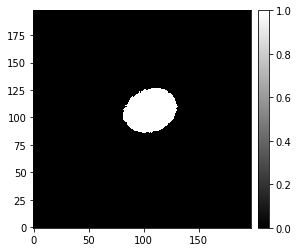

In [20]:
user_mask = np.copy(image_mask)
user_mask_delensed = lensing_op_class.image2source_2d(user_mask)
user_mask_delensed_eroded = apply_erosion(user_mask_delensed, strength=erosion_strength)

im = plt.imshow(user_mask_delensed_eroded, cmap='gray', origin='lower')
nice_colorbar(im)
plt.show()

## Reduce the source plane to minimal required size

In order to reduce runtime, we want the source plane to be the smallest possible. The minimal size is given by the intersection between the pixels that have a corresponding image plane pixel (the above pattern), and the optional mask provided by the user in the image plane, ray-traced to source plane.

In [21]:
with_user_mask = True
if with_user_mask:
    # compute intersection of user mask and source plane mask
    mask_effective = np.zeros_like(user_mask_delensed)
    mask_effective[(ones_delensed_eroded == 1.) & (user_mask_delensed_eroded == 1.)] = 1.
else:
    mask_effective = ones_delensed_eroded

(4356,)


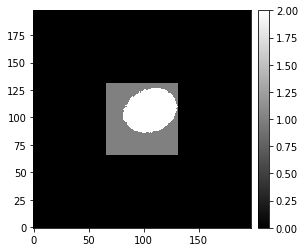

In [22]:
# iteratively construct the minimal sized square that contain the non-zero area

from slitronomy.Lensing.lensing_planes import SourcePlaneGrid

mask_final, num_pix_src_final = SourcePlaneGrid.reduce_plane_iterative(mask_effective, min_num_pix=10)
mask_final = mask_final.astype(int)

print(mask_final[mask_final == 1].shape)
im = plt.imshow(mask_final+mask_effective, cmap='gray', origin='lower')
nice_colorbar(im)
plt.show()

(4356,)


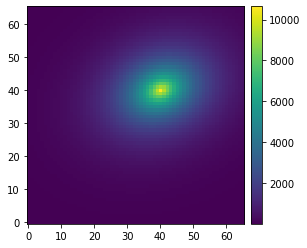

In [23]:
# get the coordinates arrays of the _reduced_ source plane
mask_final_1d = lenstro_util.image2array(mask_final)
x_grid_src_final_1d = x_grid_src_1d[mask_final_1d == 1]
y_grid_src_final_1d = y_grid_src_1d[mask_final_1d == 1]

#x_grid_src_final_1d, y_grid_src_final_1d = lenstro_util.make_grid(numPix=num_pix_src_final, 
#                                                                  deltapix=delta_pix/subgrid_res_source,
#                                                                  subgrid_res=1)
print(x_grid_src_final_1d.shape)
theta_x_src_final_1d = x_grid_src_final_1d
theta_y_src_final_1d = y_grid_src_final_1d

# get the light distribution in source plane on the final _reduced_ source plane
source_sim_final_1d = source_model_class.surface_brightness(theta_x_src_final_1d, theta_y_src_final_1d, kwargs_source)
source_sim_final = lenstro_util.array2image(source_sim_final_1d)
im = plt.imshow(source_sim_final, origin='lower')
nice_colorbar(im)
plt.show()